# Lyft Bike Share Data Bay Area

Vsualizations of Lyft bike share usage in 2020. See [Sources](http://localhost:8888/notebooks/Desktop/Lyft%20Bike%20Project.ipynb#Sources) for details on data and processes.

### Research Question: How has behavior changed pre/post Covid?


### Things to Come Back to
* Ensuring no dupes across CSV files
* Getting data from website


#### Things Complete
* Start date as own variable, not overwritten
* Cleaning up April data in March file
* Cleaning up (0,0) rides
* Consolidating data clean up
* Re-indexing joined files
* Querying by condition (rides by day where covid=1, most popular station where member)
* Mapping points to city bounds
* Drop bad cells and update queries (NANs)
* Putting shape files somewhere publicly accessible
* Getting data April - forward

In [1]:
## Imports - General
import matplotlib.pyplot as plt
import numpy             as np
import matplotlib        as matplotlib
import pandas            as pd
from   datetime          import datetime

%matplotlib inline

## Imports - Plotting

import descartes
import geopandas as gpd
import glob
from shapely.geometry import Point, polygon

## Imports - Zip File
import os
import tarfile
from six.moves import urllib
import zipfile

In [5]:
## Reading in Q1 CSVs

df1 = pd.concat([pd.read_csv(f) for f in glob.glob('/Users/kailinkoch/Desktop/Baywheels Python Practice/baywheels-project/datasets/baywheelsdata/Q1/2020*-baywheels-tripdata.csv')], ignore_index=True)

In [6]:
## Get April + June, because they have the same nice and easy columns, which we're renaming to match the Q1 data

cols=['ride_id','rideable_type','start_time','end_time','start_station_name','start_station_id','end_station_name','end_station_id','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude','rental_access_method']
df2 = pd.concat([pd.read_csv(f, header=0, names=cols) for f in \
glob.glob('/Users/kailinkoch/Desktop/Baywheels Python Practice/baywheels-project/datasets/baywheelsdata/Q2/AprJune/2020*-baywheels-tripdata.csv')]\
, ignore_index=True)

In [7]:
## May has an add'l 'is_equity' column that breaks the column labelling.

cols=['ride_id','rideable_type','start_time','end_time','start_station_name','start_station_id','end_station_name','end_station_id','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude','rental_access_method', 'is_equity']
df_may = pd.read_csv('/Users/kailinkoch/Desktop/Baywheels Python Practice/baywheels-project/datasets/baywheelsdata/Q2/202005-baywheels-tripdata.csv', header=0,names=cols)

In [8]:
## join the 2 dataframes together

df = pd.concat([df1,df2,df_may], join='inner')
df.head()

,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,rental_access_method
0,2020-01-31 15:23:47.7330,2020-02-01 14:29:06.2630,400.0,Buchanan St at North Point St,37.804272,-122.433537,400.0,Buchanan St at North Point St,37.804272,-122.433537,NaN
1,2020-01-31 15:40:31.6160,2020-02-01 10:37:51.0000,99.0,Folsom St at 15th St,37.767037,-122.415443,99.0,Folsom St at 15th St,37.767037,-122.415443,NaN
2,2020-01-31 17:48:16.6350,2020-02-01 09:11:44.3170,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,NaN
3,2020-01-31 17:53:03.4130,2020-02-01 09:08:32.6340,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,NaN
4,2020-01-31 17:12:33.4600,2020-02-01 08:40:53.6460,12.0,Pier 1/2 at The Embarcadero,37.796389,-122.394586,371.0,Lombard St at Columbus Ave,37.802746,-122.413579,NaN


## Cleaning Up Data Set

* Small number (24 records) of records are from the `16th St Fleet Depot`. These records have a coordinate of (0,0) and it is not clear that these are legitimate rides. As such, I am updating them to `NaN` to ensure the proper display of the chart.
* Remove partial weeks at beginning/end of data set
* Adding additional date fields
* Creating binary COVID variable

In [9]:
## Identify number of records where starting coordinates = (0,0)

min_latitude = min(df.start_station_latitude)
max_longitude = max(df.start_station_longitude)
print(f'the min latitude is {min_latitude}')
print(f'the max longitude is {max_longitude}')

the min latitude is 0.0
the max longitude is 0.0


In [10]:
## Updating (0,0) entries to Nan
df.loc[df['start_station_latitude'] == 0].count()
df.loc[df['start_station_longitude'] == 0].count()
       
df = df.loc[df['start_station_latitude'] != 0]
df = df.loc[df['start_station_longitude'] != 0]

In [11]:
## Confirming the above was done properly

min_latitude =  min(df.start_station_latitude)
max_longitude = max(df.start_station_longitude)
print(f'the min latitude is {min_latitude}')
print(f'the max longitude is {max_longitude}')

the min latitude is 37.2392
the max longitude is -121.77


In [12]:
## Populating basic date fields 

df["start_time"]  = pd.to_datetime(df["start_time"])
df1["start_time"]  = pd.to_datetime(df1["start_time"])
df["start_date"]  = df["start_time"].dt.date
df['first_day'] = df['start_time'] - df['start_time'].dt.weekday * np.timedelta64(1, 'D')
df['first_day'] = df['first_day'].dt.date
df['day_of_week'] = df['start_time'].dt.weekday
df['covid']    = 0


In [13]:
## Removing partial weeks
df = df.loc[df['start_time'] >= '01/06/20']
df = df.loc[df['start_time'] < '06/29/20']

In [14]:
## Make a Binary Pre-Post Covid Variable (Shelter in Place takes effect on 3/17)

df.loc[df['start_time'] >= '3/17/20', 'covid'] = 1
df.loc[df['start_time'] <  '3/17/20', 'covid'] = 0

### Adding the Shape Files
* Using zip for visualization
* Have some additional options below

In [27]:
#bay_area = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7hs4j-shapefile/s7hs4j.shp')
#bay_area_counties = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7hs4j-shapefile (1)/s7hs4j.shp')
#bay_area_cities = gpd.read_file('/Users/kailinkoch/Downloads/stanford-vj593xs7263-shapefile/vj593xs7263.shp')

In [18]:
bay_area_zips = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7888q-shapefile/s7888q.shp')
bay_area_transit=gpd.read_file('/Users/kailinkoch/Downloads/stanford-jb610tp4726-shapefile/jb610tp4726.shp')
san_francisco_parks = gpd.read_file('/Users/kailinkoch/Downloads/stanford-fy797sg6480-shapefile/fy797sg6480.shp')

### Creating the GeoDataFrame

In [15]:
## Turn coordinates into geometric point

geometry = [Point(xy) for xy in zip(df["start_station_longitude"], df["start_station_latitude"])]

In [16]:
## Get all the data ready for the chart

geo_df = gpd.GeoDataFrame(df,
                          crs='EPSG:4326', ## CRS matches shape file (bay_area_zips)
                          geometry=geometry)

In [19]:
## Get the individual points mapped to their corresponding zip code

geo_df_with_zips = gpd.sjoin(geo_df, bay_area_zips, how='inner', op ='within')

In [20]:
## Just SF Data

geo_df_with_zips_sf = geo_df_with_zips.loc[geo_df_with_zips['PO_NAME']=='SAN FRANCISCO']

### Basic Information
- How have top stations changed pre/post Covid?
- How does rides by week changed pre/post Covid?

In [21]:
## How many rides in this data set? How many are pre-COVID?

total_rides = (geo_df_with_zips_sf['start_time'].count())
print(f'There are {total_rides} total rides in this data set')

precovid=geo_df_with_zips_sf.loc[geo_df_with_zips_sf['covid']==0]
postcovid=geo_df_with_zips_sf.loc[geo_df_with_zips_sf['covid']==1]

precovid_rides = precovid['start_time'].count()
print(f'There are {precovid_rides} rides from Pre-COVID in this data set')

There are 1022941 total rides in this data set
There are 708187 rides from Pre-COVID in this data set


In [40]:
## Rides by Day of Week 
dayofweek_precovid = precovid["start_time"].dt.weekday.value_counts().sort_index()
dayofweek_postcovid = postcovid["start_time"].dt.weekday.value_counts().sort_index()
dayofweek_precovid_weekday =precovid.loc[precovid['day_of_week'] <=4]
dayofweek_precovid_weekend =precovid.loc[precovid['day_of_week'] >4]
dayofweek_postcovid_weekday =postcovid.loc[postcovid['day_of_week'] <=4]
dayofweek_postcovid_weekend =postcovid.loc[postcovid['day_of_week'] >4]

daytype = {'before_covid19': [round(dayofweek_precovid_weekend['start_date'].value_counts().mean()),round(dayofweek_precovid_weekday['start_date'].value_counts().mean())],\
           'since_covid19': [round(dayofweek_postcovid_weekend['start_date'].value_counts().mean()), round(dayofweek_postcovid_weekday['start_date'].value_counts().mean())]}
daytype =pd.DataFrame(data=daytype)
daytype.rename(index={0:"weekend_day",1:"week_day"}, inplace=True)
daytype

,before_covid19,since_covid19
weekend_day,7643,3758
week_day,10889,2730


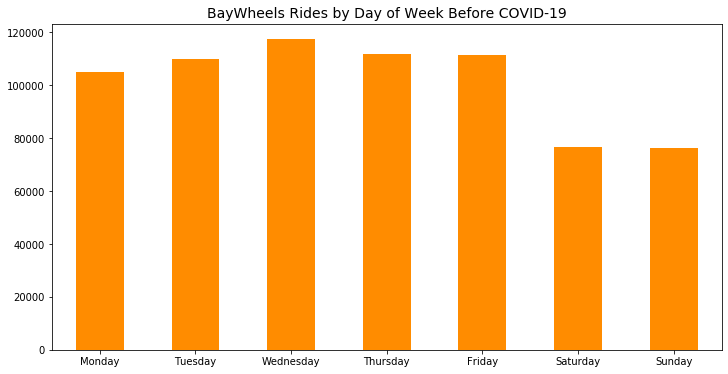

In [41]:
## Rides by Day of Week (PreCovid, 0 == Monday, 6 == Sunday)

fig,ax = plt.subplots(figsize=(12,6))
dayofweek_figure = dayofweek_precovid.plot(kind = 'bar', color = 'darkorange')

plt.Axes.set_xticklabels(dayofweek_figure,labels = ['Monday', 'Tuesday','Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation = 0)
plt.title('BayWheels Rides by Day of Week Before COVID-19', fontsize = 14, loc ='center')

## Same pattern for casual vs. annual
fig.savefig('baywheels_rides_by_dayofweek_before_covid19_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

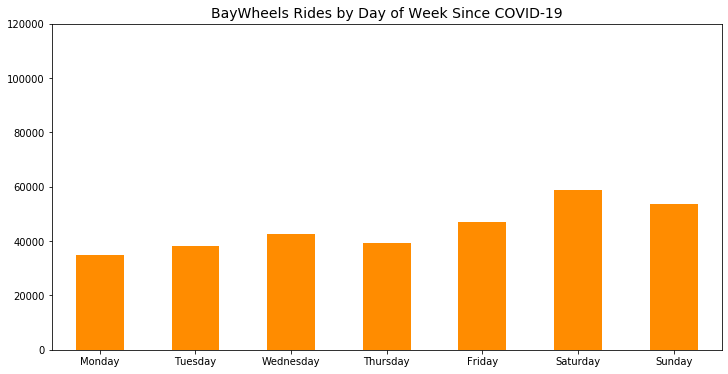

In [42]:
## Rides by Day of Week (PostCovid, 0 == Monday, 6 == Sunday)
fig,ax = plt.subplots(figsize=(12,6))
dayofweek_figure = dayofweek_postcovid.plot(kind = 'bar', color = 'darkorange')
ax.set(ylim=[0, 120000])
plt.Axes.set_xticklabels(dayofweek_figure,labels = ['Monday', 'Tuesday','Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation = 0)
plt.title('BayWheels Rides by Day of Week Since COVID-19', fontsize = 14, loc ='center')
## Same pattern for casual vs. annual

## Same pattern for casual vs. annual
fig.savefig('baywheels_rides_by_dayofweek_since_covid19_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

In [110]:
## Get Counts by Pre/Post COVID by station

dfpivot_precovid_top = pd.pivot_table(precovid,index=['start_station_name'],values='start_date',aggfunc={'start_date':'count'})
dfpivot_precovid_top.reset_index(inplace=True)
dfpivot_precovid_top.rename({"start_date": "count"}, axis='columns', inplace=True)
dfpivot_precovid_top.sort_values(by='count',ascending=False, inplace=True)
dfpivot_precovid_top = dfpivot_precovid_top.head(10)

dfpivot_postcovid_top = pd.pivot_table(postcovid,index=['start_station_name'],values='start_date',aggfunc={'start_date':'count'})
dfpivot_postcovid_top.reset_index(inplace=True)
dfpivot_postcovid_top.rename({"start_date": "count"}, axis='columns', inplace=True)
dfpivot_postcovid_top.sort_values(by='count',ascending=False, inplace=True)
dfpivot_postcovid_top = dfpivot_postcovid_top.head(10)
dfpivot_precovid_top

,start_station_name,count
152,Market St at 10th St,7059
197,San Francisco Caltrain (Townsend St at 4th St),7001
52,Berry St at 4th St,6105
130,Howard St at Beale St,5068
155,Market St at Steuart St,4740
186,Powell St BART Station (Market St at 4th St),4485
200,San Francisco Ferry Building (Harry Bridges Pl...,4400
187,Powell St BART Station (Market St at 5th St),4303
168,Montgomery St BART Station (Market St at 2nd St),4183
193,Rhode Island St at 17th St,3157


In [58]:
## Getting coordiantes for top stations

def top_station_mapping(dfpivot_top, table):
    top_stations=pd.DataFrame()
    for station in dfpivot_top['start_station_name']:
        station_details = table.loc[table['start_station_name']==station].head(1)
        top_stations =top_stations.append(station_details)
    top_stations.reset_index()
    return top_stations

precovid_topstations_visualization = top_station_mapping(dfpivot_precovid_top, precovid)
postcovid_topstations_visualization = top_station_mapping(dfpivot_postcovid_top, postcovid)
station_visualization = precovid_topstations_visualization.append(postcovid_topstations_visualization)

/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


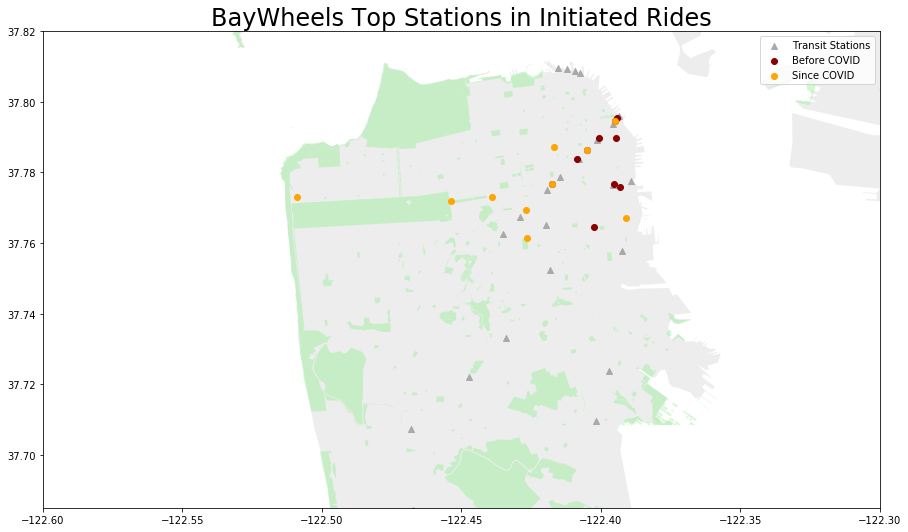

In [59]:

fig,ax=plt.subplots(figsize=(15,15))
ax.set(xlim=[-122.6,-122.3], ylim=[37.685,37.82], aspect=1)
bay_area_zips.plot(ax = ax, figsize=(15,15), alpha=0.4, color='lightgrey')
san_francisco_parks.plot(ax = ax, figsize=(15,15), alpha=0.4, color='lightgreen')
bay_area_transit.plot(ax = ax,color='darkgrey', marker='^',label = 'Transit Stations')
station_visualization[station_visualization['covid']==0].plot(ax = ax, column='count',color='darkred', label ='Before COVID')
station_visualization[station_visualization['covid']==1].plot(ax = ax, column='count',color='orange', label ='Since COVID')
plt.legend()
plt.title('BayWheels Top Stations in Initiated Rides', fontsize=24, loc='center')

fig.savefig('top_stations_mapped'+'.png', facecolor='white', dpi=150, bbox_inches='tight')

In [43]:
## Get Average Daily Rides pre and post COVID

dfpivot_precovid_rides = pd.pivot_table(precovid,index=['start_date'],values='start_station_longitude',aggfunc={'start_date':'count'})
dfpivot_precovid_rides.rename({"start_date": "count"}, axis='columns', inplace=True)
dfpivot_precovid_rides.reset_index(inplace = True)


dfpivot_postcovid_rides = pd.pivot_table(postcovid,index=['start_date'],values='start_station_longitude',aggfunc={'start_date':'count'})
dfpivot_postcovid_rides.rename({"start_date": "count"}, axis='columns', inplace=True)
dfpivot_postcovid_rides.reset_index(inplace = True)
means = {'before_covid' : [round(dfpivot_precovid_rides['count'].mean())], 'since_covid' : [round(dfpivot_postcovid_rides['count'].mean())]}
means_df = pd.DataFrame(data=means)
means_df.rename(index={0:"daily_ride_avg"}, inplace=True)
means_df


,before_covid,since_covid
daily_ride_avg,9974,3026


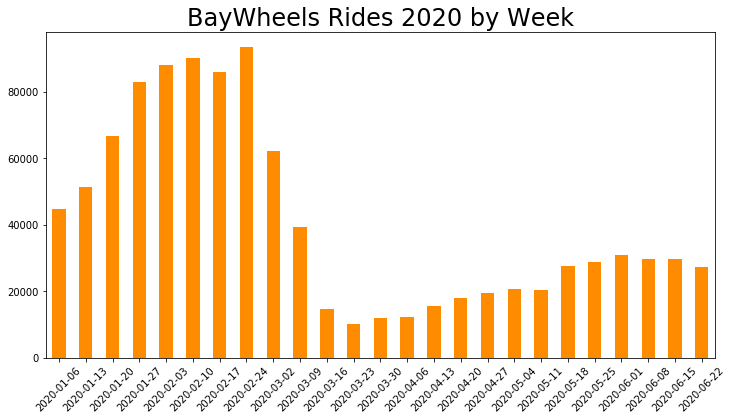

In [44]:
# 2020 Rides by Week

rides_by_week=geo_df_with_zips_sf['first_day'].value_counts().sort_index()
fig,ax = plt.subplots(figsize=(12,6))
rides_by_week_figure=rides_by_week.plot(ax=ax, kind='bar', color='darkorange')
plt.title('BayWheels Rides 2020 by Week', fontsize=24, loc='center')
plt.xticks(rotation=45)

fig.savefig('baywheels_rides_by_week_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')
        

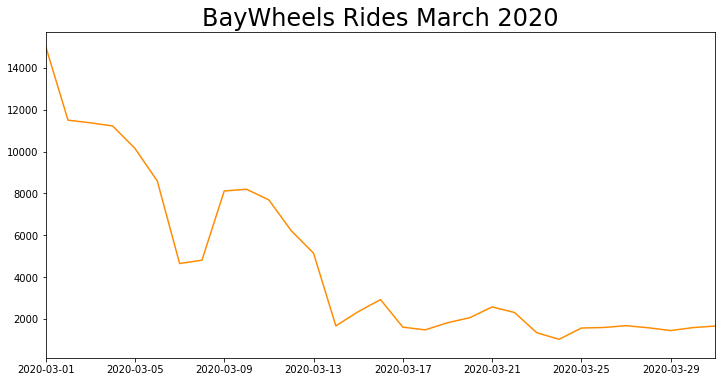

In [45]:
## Rides by day in March?
rides_by_day=geo_df_with_zips_sf['start_date'].value_counts().sort_index()
fig,ax = plt.subplots(figsize=(12,6))
rides_by_day.plot(ax=ax,kind='line', xlim= ['3/1/20', '3/31/20'], color='darkorange')
plt.title('BayWheels Rides March 2020', fontsize=24, loc='center')

fig.savefig('baywheels_rides_by_day_march_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

In [62]:
index = geo_df_with_zips_sf.index

In [63]:
## Gets counts by week by zip

dfpivot = pd.pivot_table(geo_df_with_zips_sf,index=['ZIP', 'first_day'],values='start_date',aggfunc={'start_date':'count'})
dfpivot.reset_index(inplace = True)
dfpivot.rename({"start_date": "count"}, axis='columns', inplace=True)
dfpivot.head()

,ZIP,first_day,count
0,94102,2020-01-06,3097
1,94102,2020-01-13,3593
2,94102,2020-01-20,4743
3,94102,2020-01-27,5822
4,94102,2020-02-03,6136


In [64]:
geo_df_with_counts = bay_area_zips.merge(dfpivot, how='inner',on='ZIP')

In [65]:
## Merge the counts back in with the geometric data

geo_df_with_counts = bay_area_zips.merge(dfpivot, how='inner',on='ZIP')
geo_df_with_counts

,ZIP,PO_NAME,STATE,Area__,Length__,geometry,first_day,count
0,94133,SAN FRANCISCO,CA,2.155245e+07,43114.362360,"MULTIPOLYGON (((-122.41920 37.80846, -122.4179...",2020-01-06,999
1,94133,SAN FRANCISCO,CA,2.155245e+07,43114.362360,"MULTIPOLYGON (((-122.41920 37.80846, -122.4179...",2020-01-13,1372
2,94133,SAN FRANCISCO,CA,2.155245e+07,43114.362360,"MULTIPOLYGON (((-122.41920 37.80846, -122.4179...",2020-01-20,2069
3,94133,SAN FRANCISCO,CA,2.155245e+07,43114.362360,"MULTIPOLYGON (((-122.41920 37.80846, -122.4179...",2020-01-27,2489
4,94133,SAN FRANCISCO,CA,2.155245e+07,43114.362360,"MULTIPOLYGON (((-122.41920 37.80846, -122.4179...",2020-02-03,2650
...,...,...,...,...,...,...,...,...
617,94134,SAN FRANCISCO,CA,6.751601e+07,44866.521548,"POLYGON ((-122.42066 37.73204, -122.41521 37.7...",2020-05-25,44
618,94134,SAN FRANCISCO,CA,6.751601e+07,44866.521548,"POLYGON ((-122.42066 37.73204, -122.41521 37.7...",2020-06-01,58
619,94134,SAN FRANCISCO,CA,6.751601e+07,44866.521548,"POLYGON ((-122.42066 37.73204, -122.41521 37.7...",2020-06-08,53
620,94134,SAN FRANCISCO,CA,6.751601e+07,44866.521548,"POLYGON ((-122.42066 37.73204, -122.41521 37.7...",2020-06-15,59


### Creating Final Visualization

In [66]:
## Function to print the graphs for the final GIF
plt.ioff()

def print_map(x):
    range = x['count']
    norm=matplotlib.colors.Normalize(vmin=range.min(), vmax=range.max())
    for week in x['first_day']:
        geo_df_with_counts_day = x.loc[x['first_day']==week]
        fig,ax=plt.subplots(figsize=(15,15))
        #ax.set(xlim=[-122.75,-121.55], ylim=[37.7,38.0], aspect=1)
        ax.set(xlim=[-122.6,-122.3], ylim=[37.685,37.82], aspect=1)
        bay_area_zips.plot(ax = ax, figsize=(15,15), alpha=0.4, color='lightgrey')
        geo_df_with_counts_day.plot(ax = ax, column='count', norm=norm, cmap='Oranges')
        plt.title('BayWheels Rides Week of '+str(week), fontsize=24, loc='center')
        sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
        sm.set_array([])
        plt.colorbar(sm,ax=ax, norm=norm,cmap='Oranges', shrink=0.48)
        fig.savefig(str(week)+'_baywheels_bywk_byzip'+ '.png', facecolor='white', dpi=150, bbox_inches='tight')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

KeyboardInterrupt: 

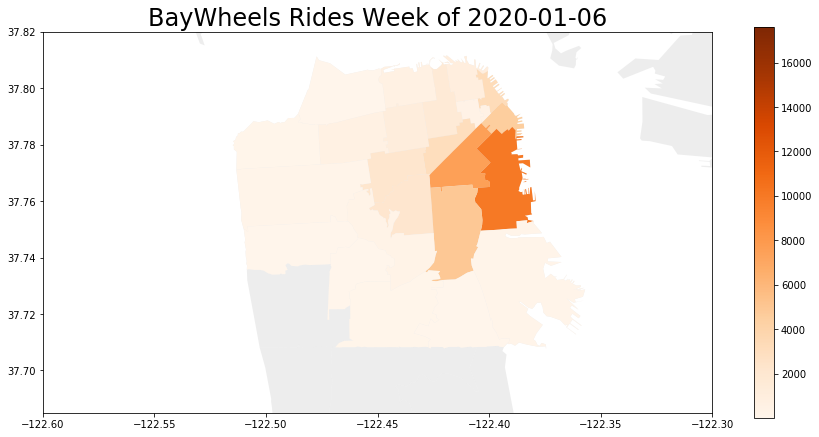

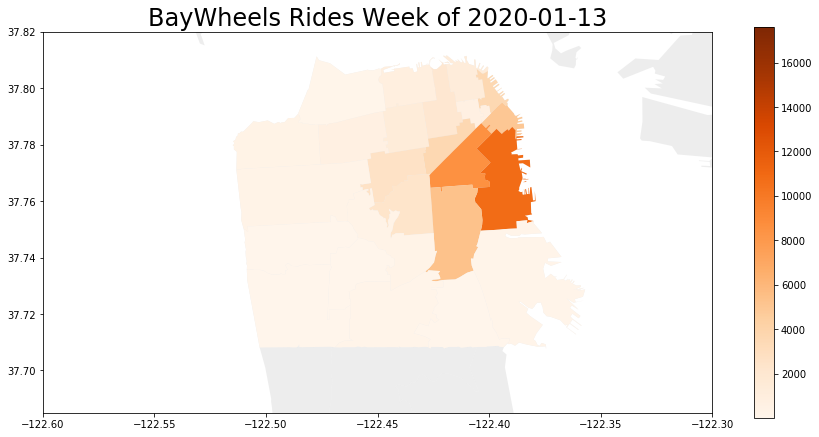

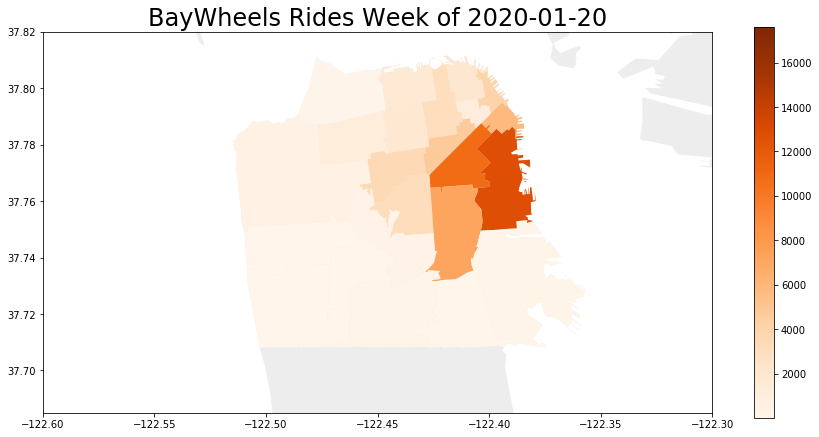

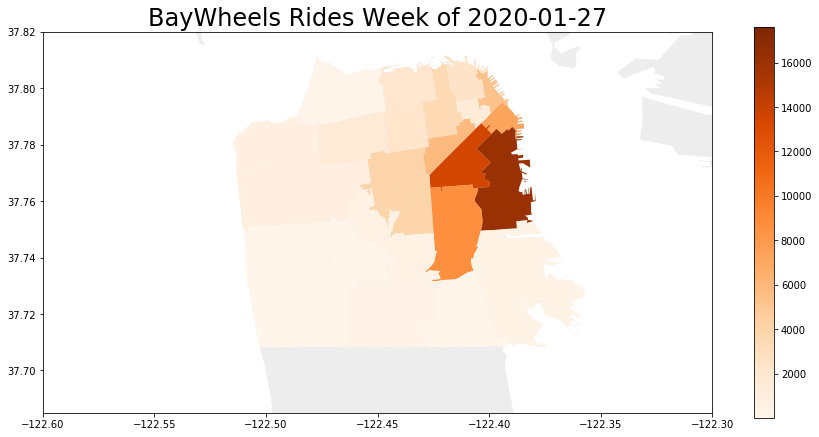

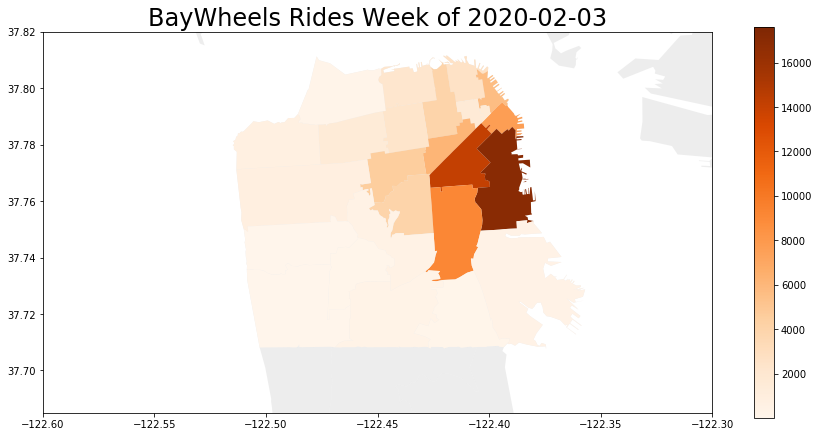

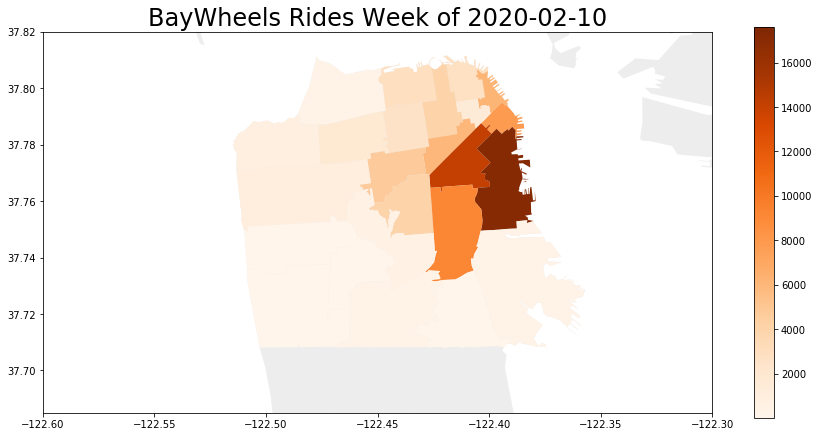

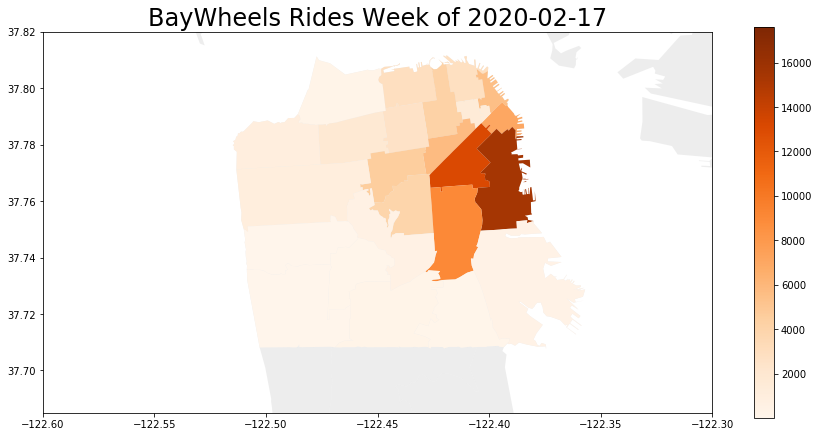

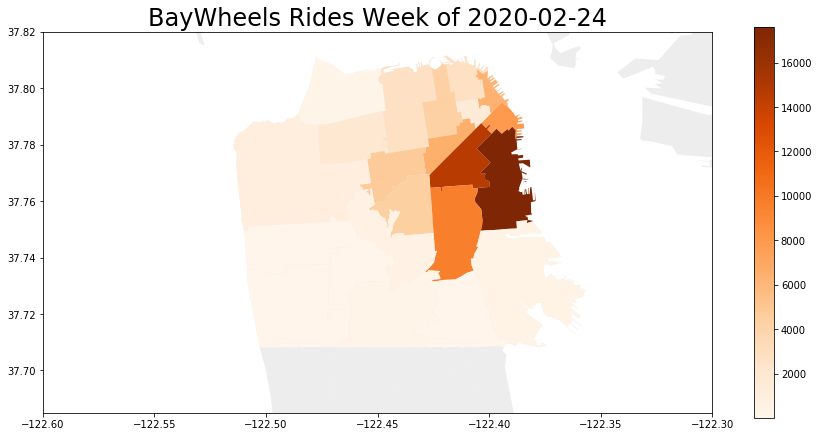

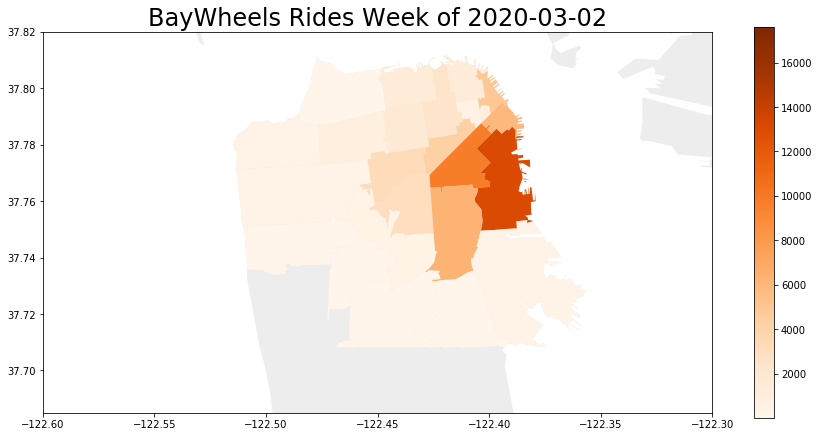

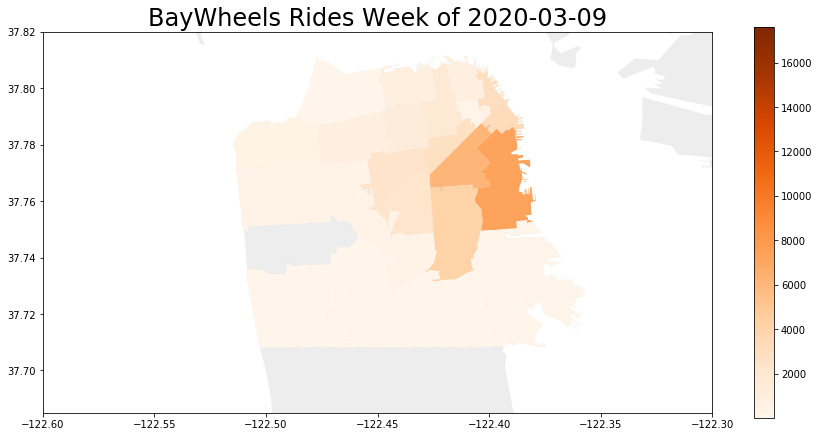

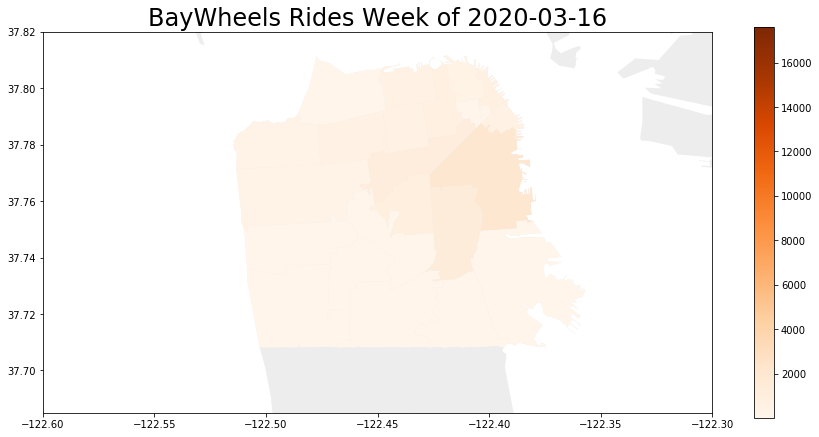

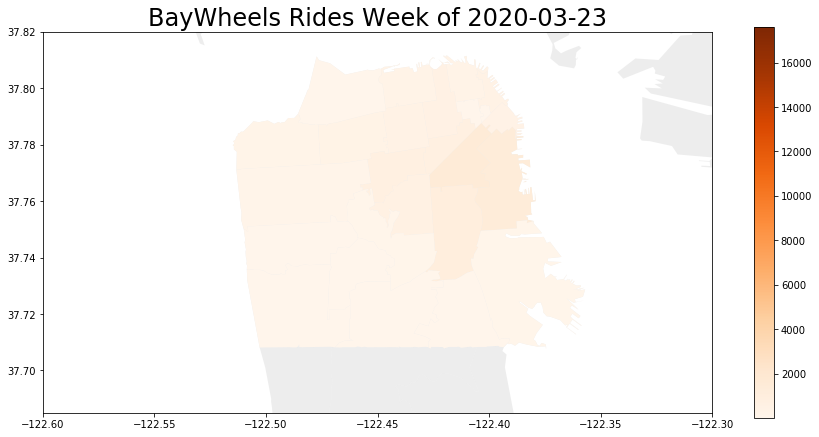

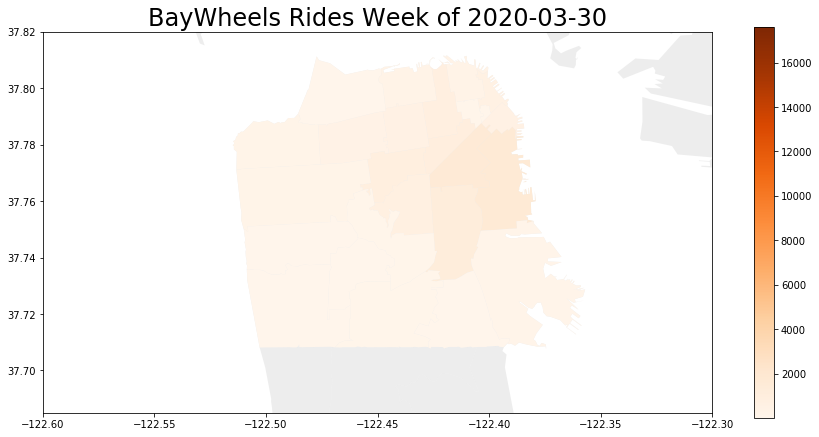

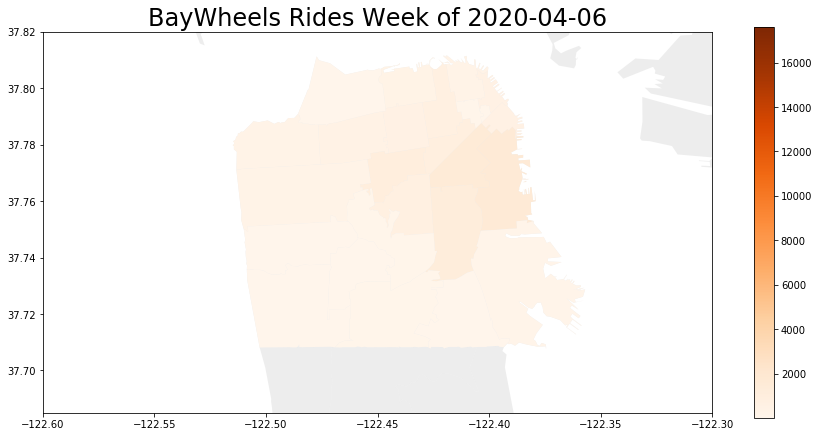

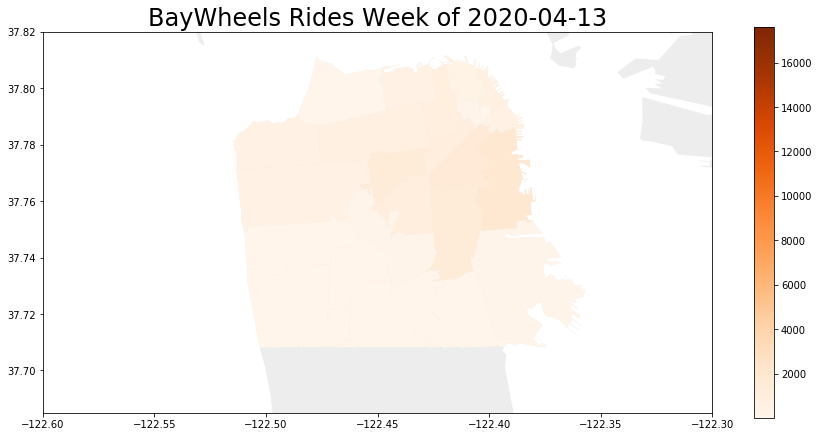

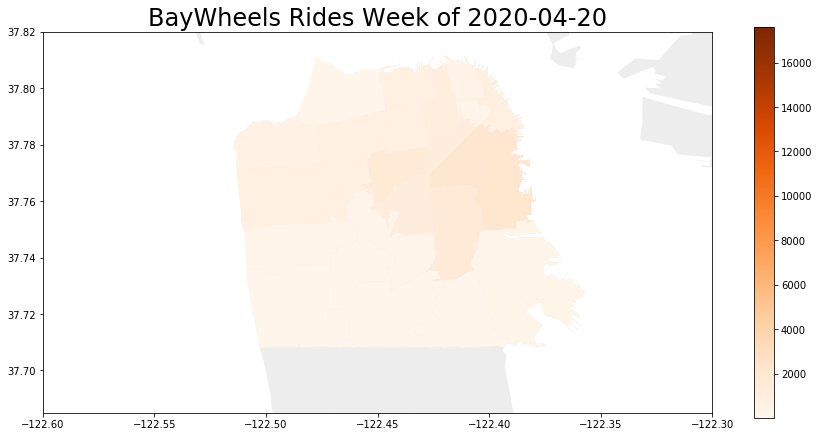

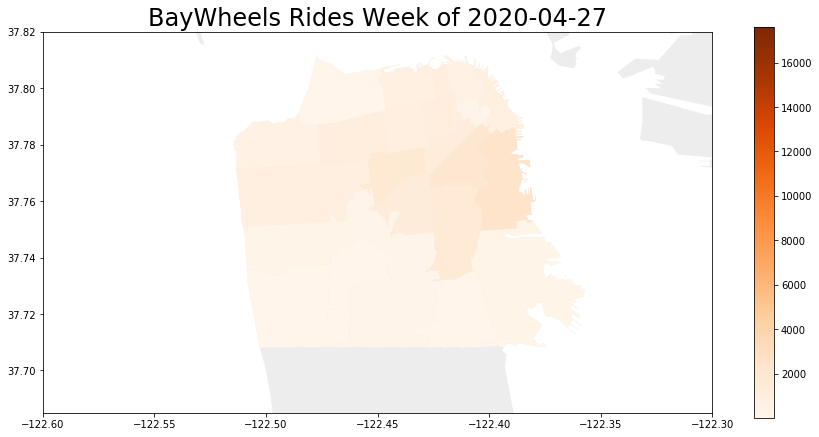

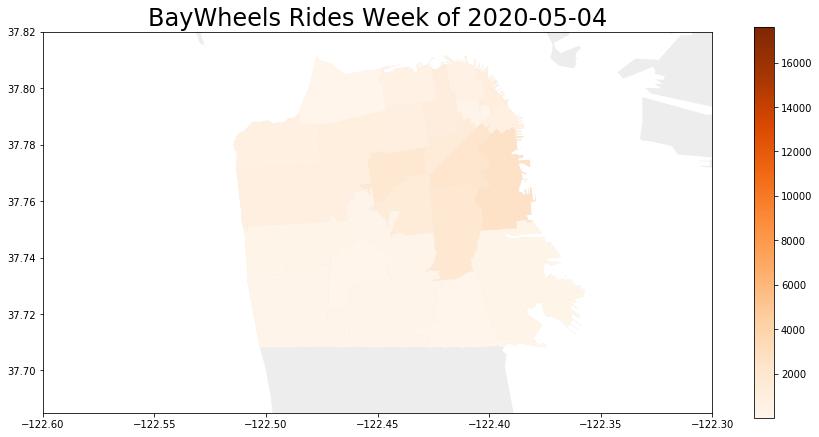

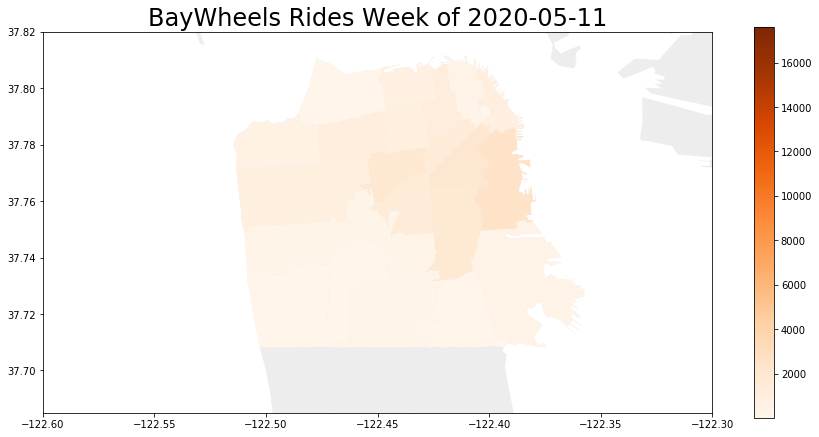

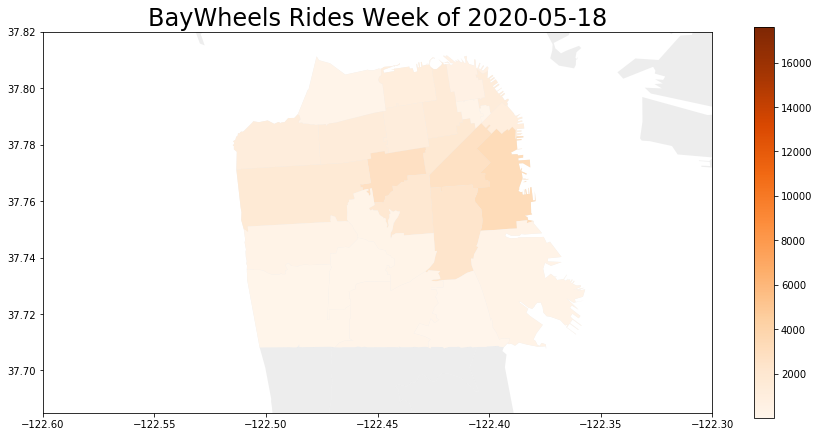

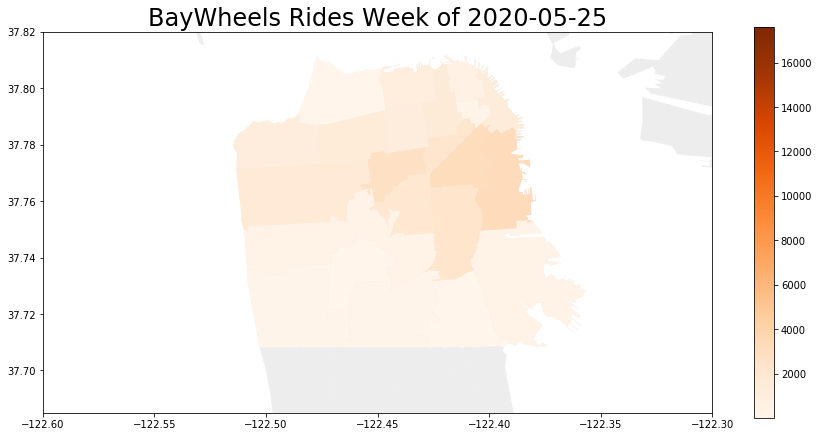

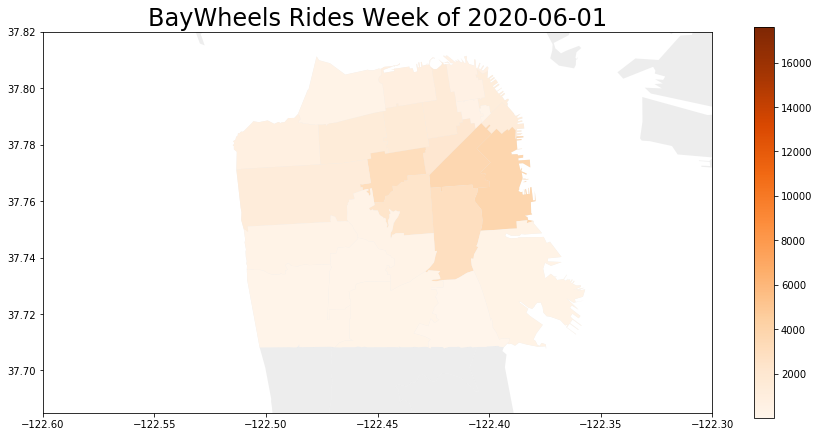

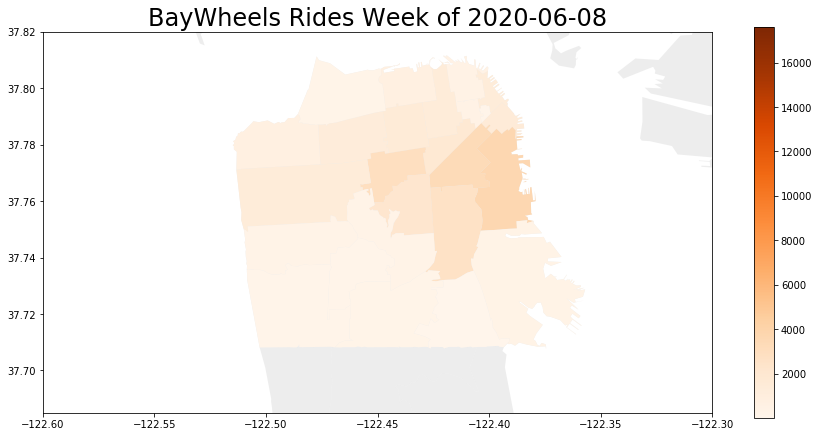

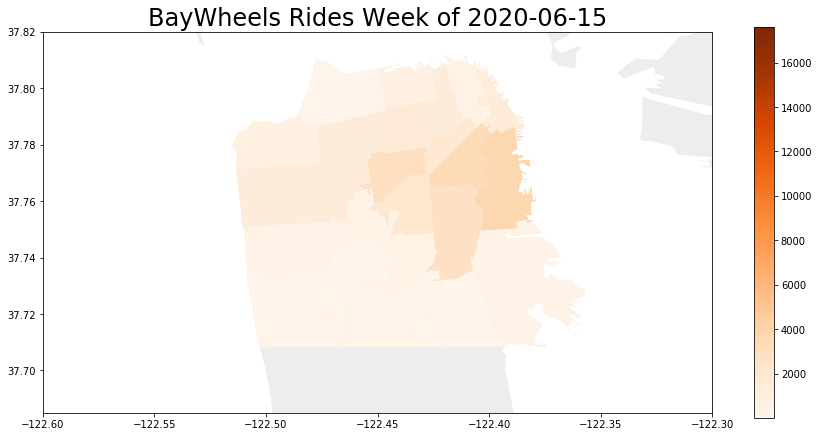

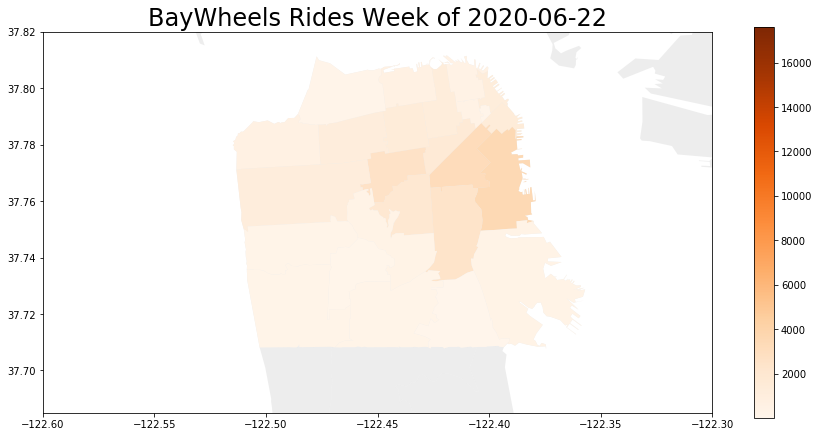

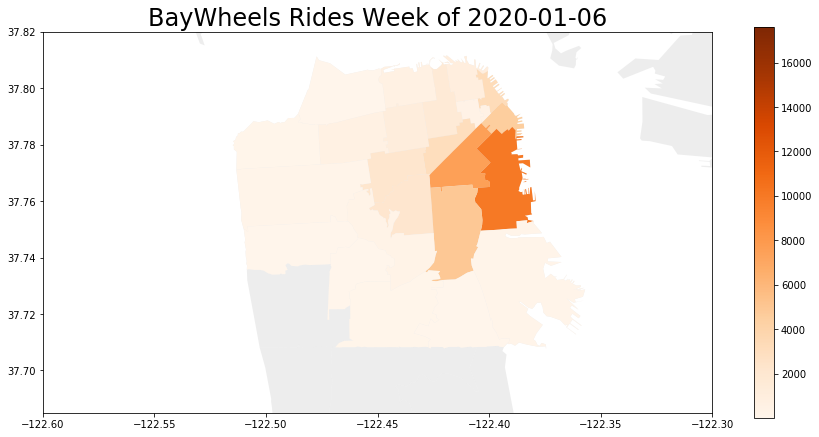

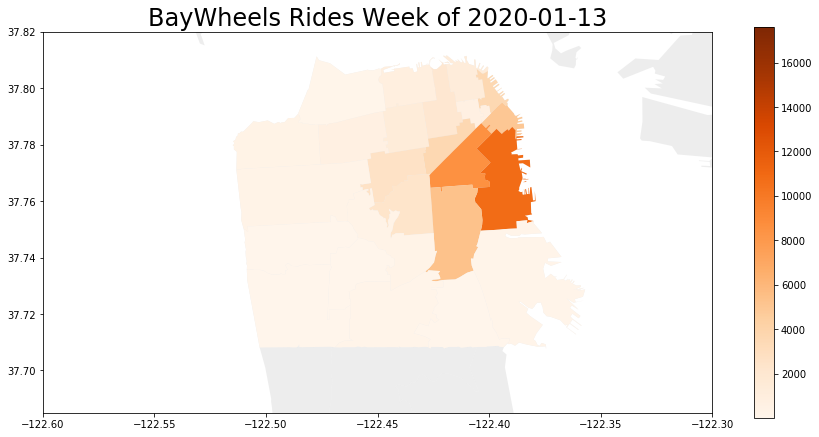

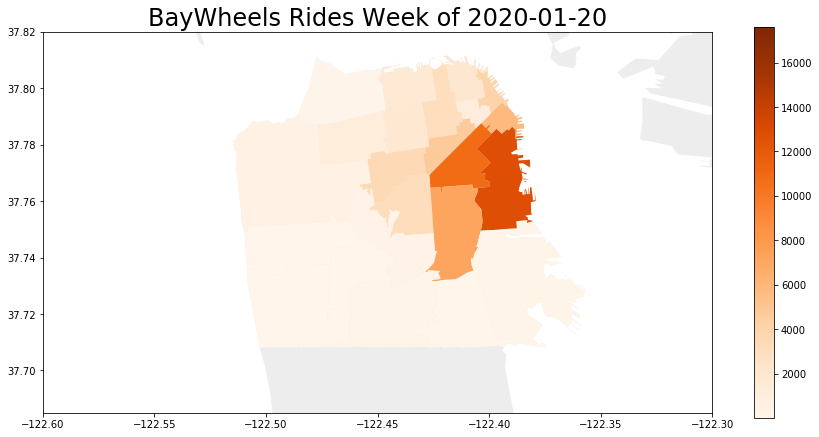

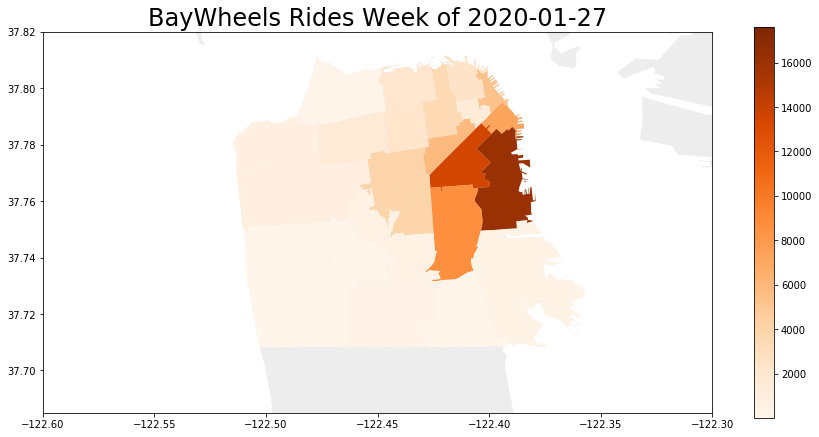

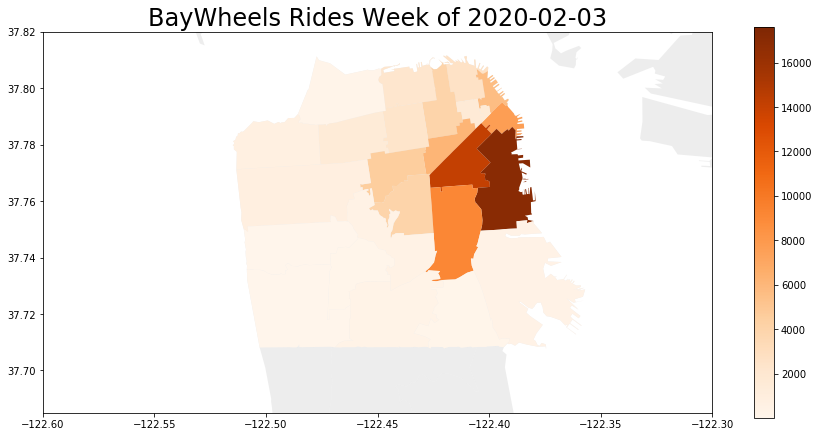

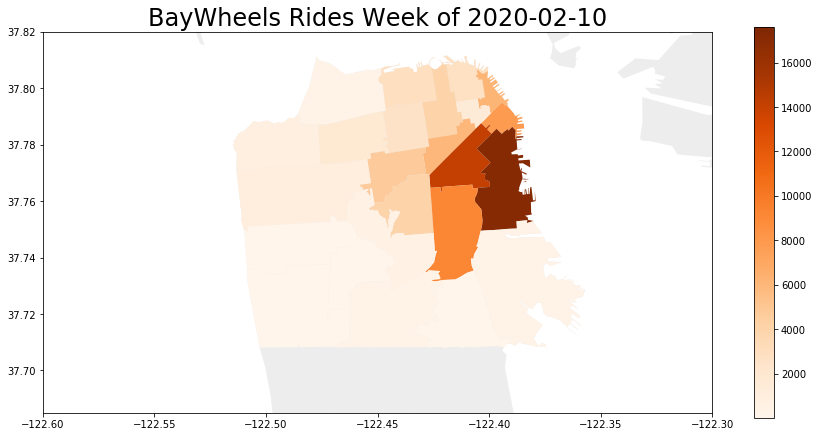

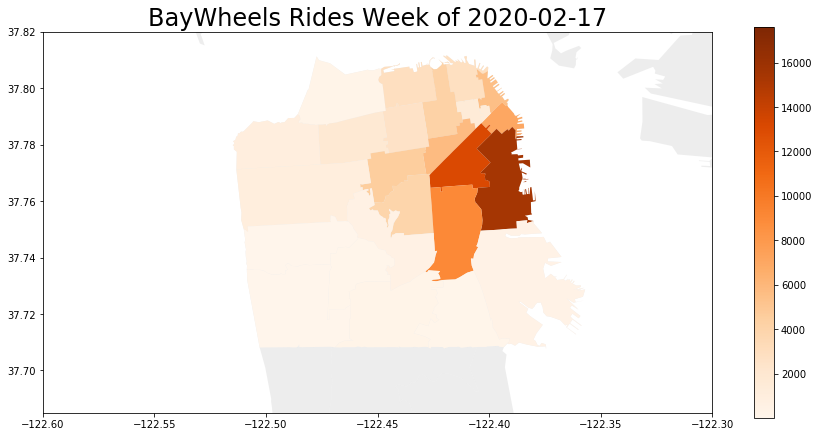

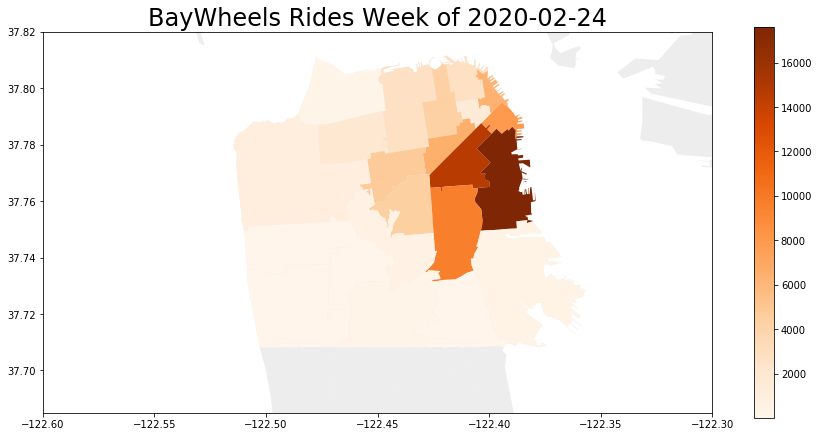

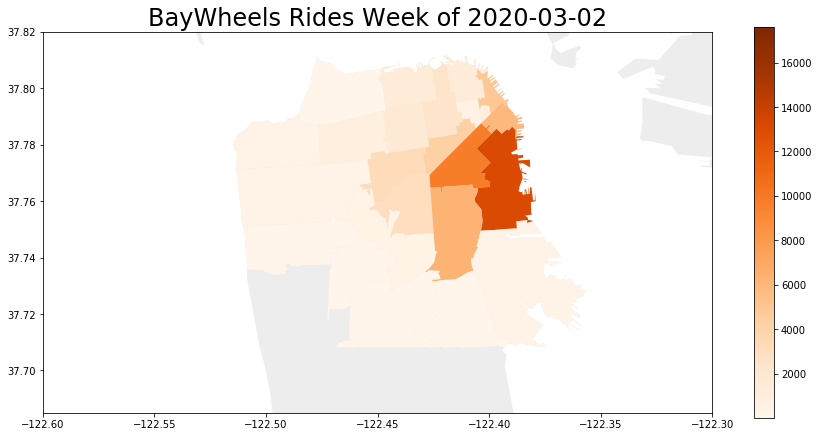

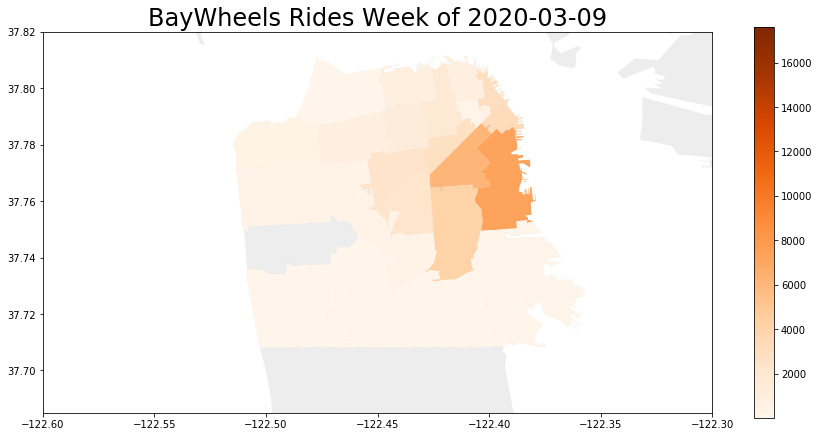

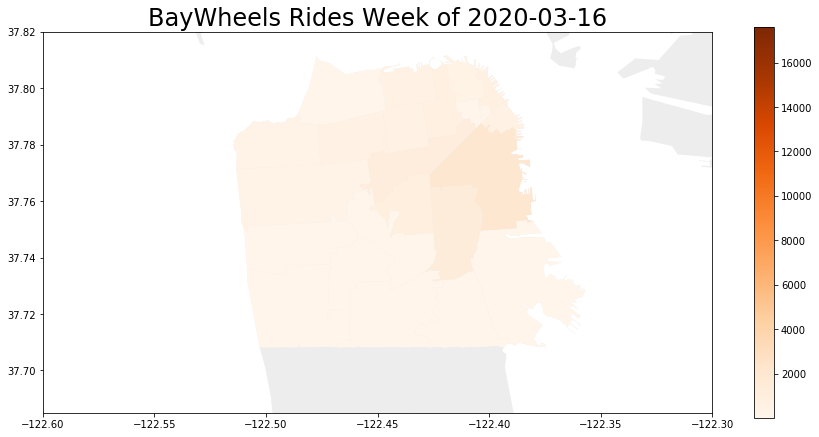

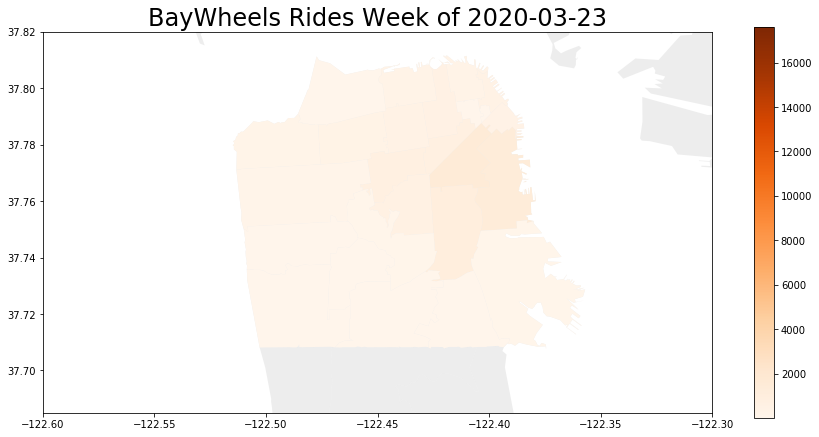

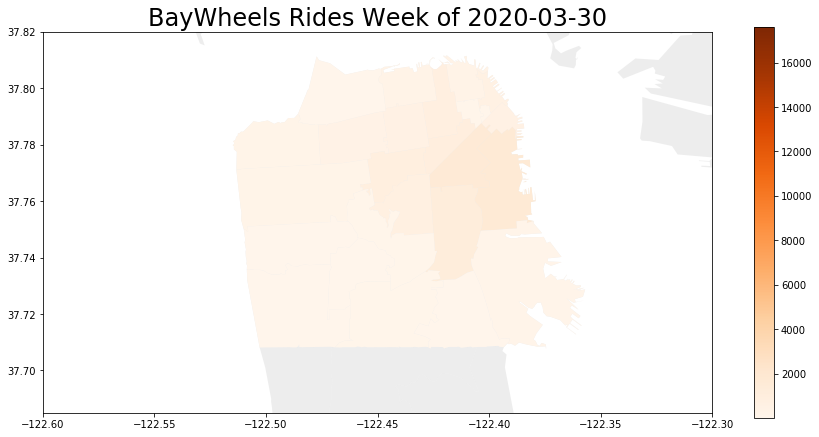

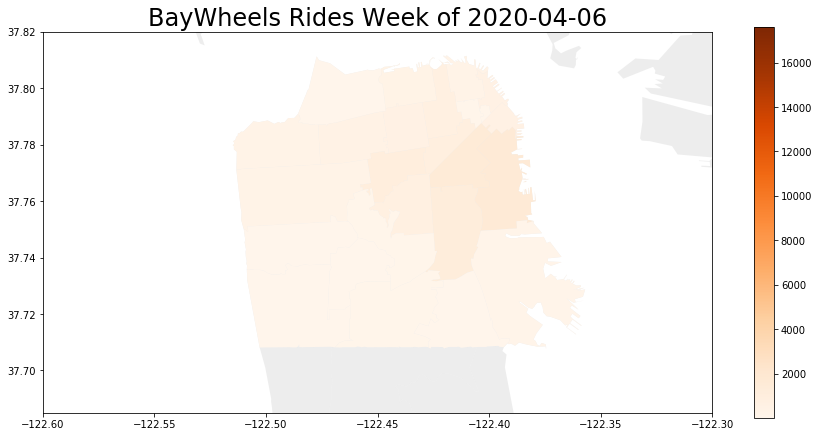

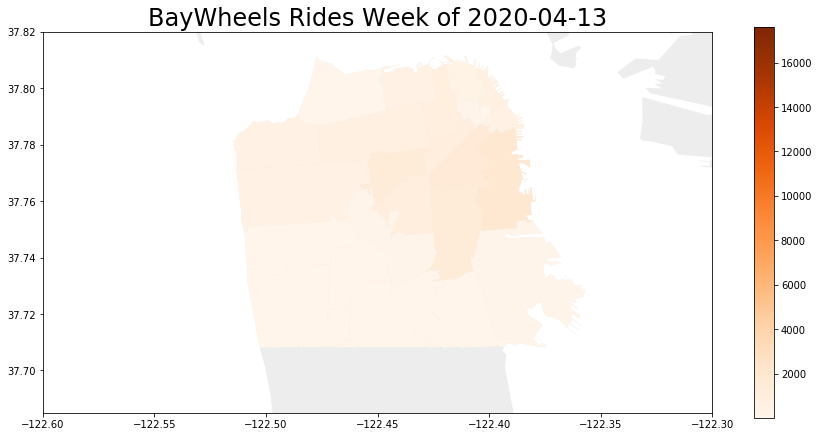

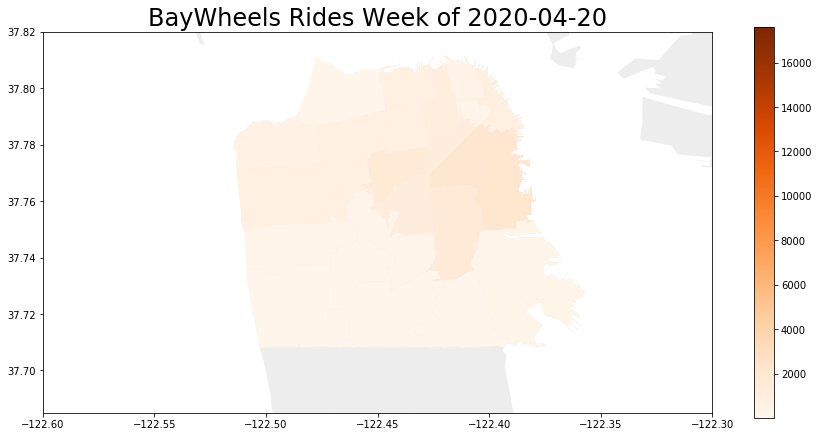

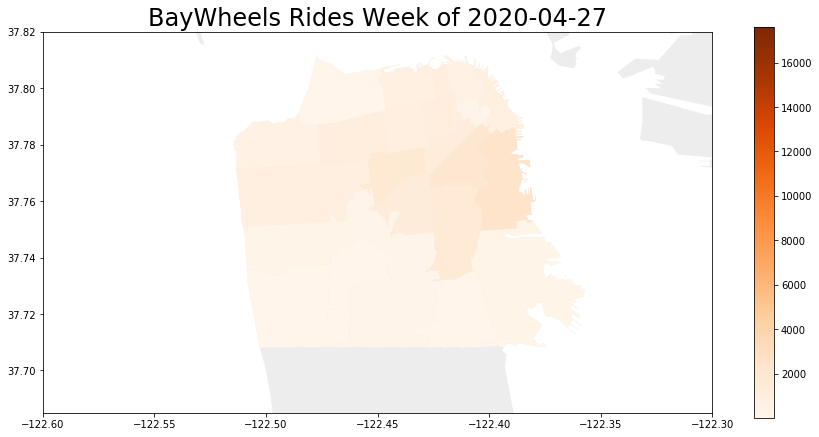

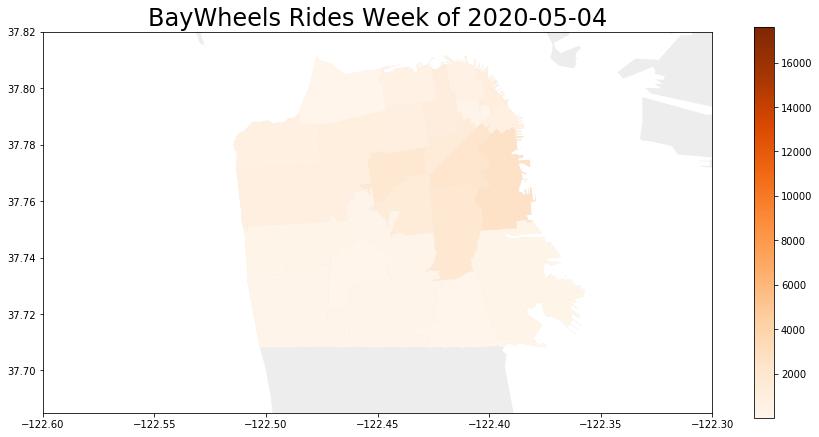

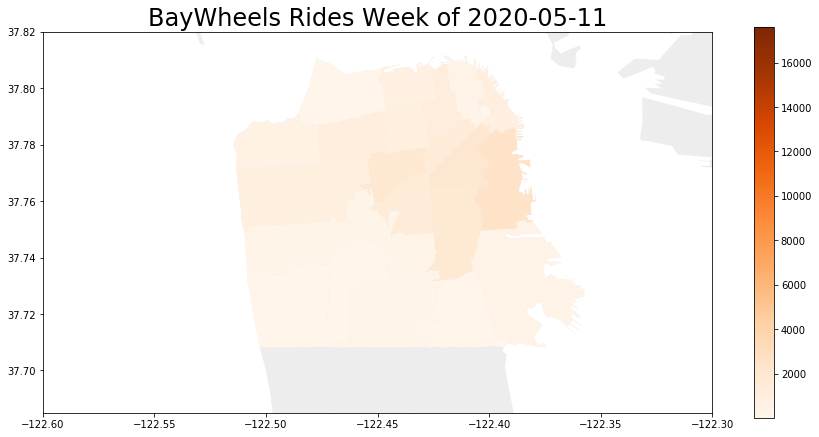

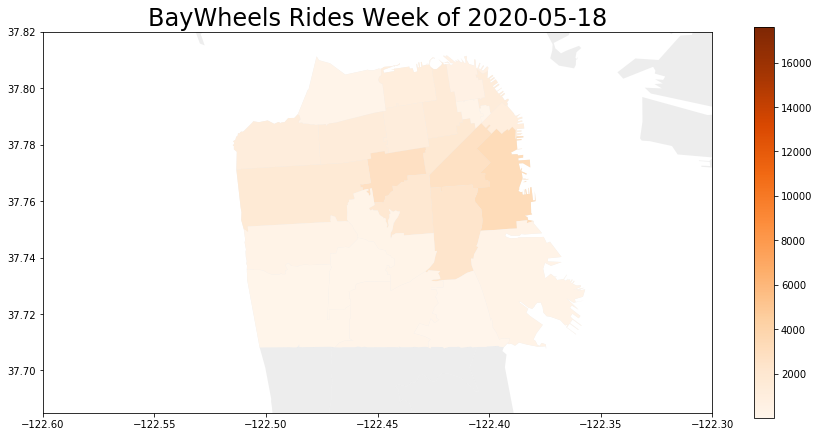

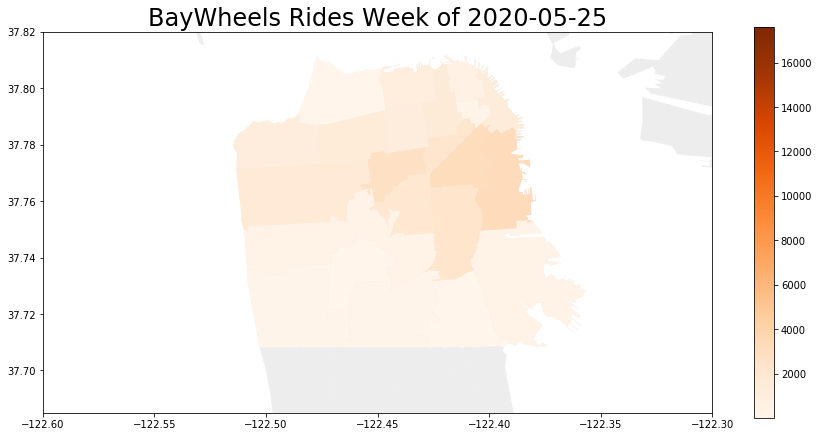

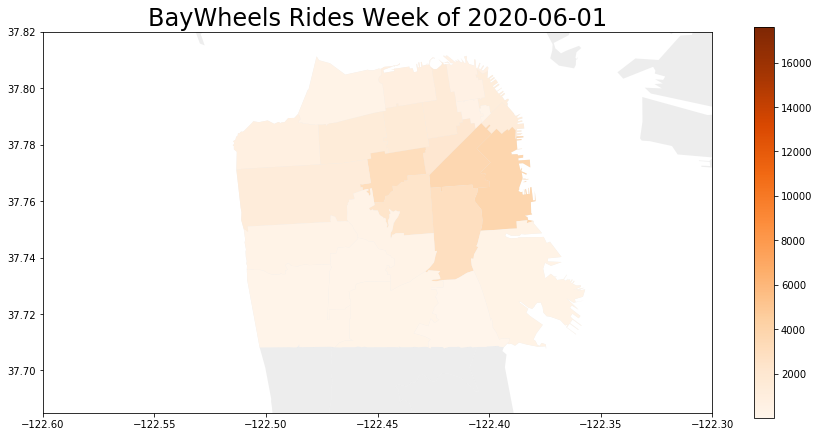

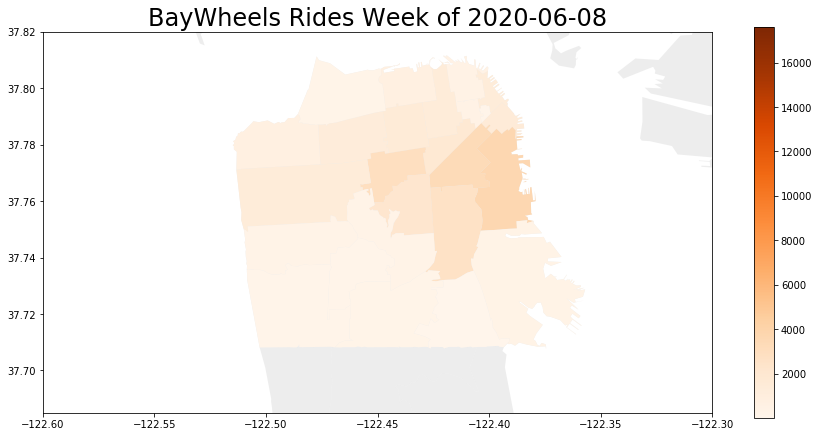

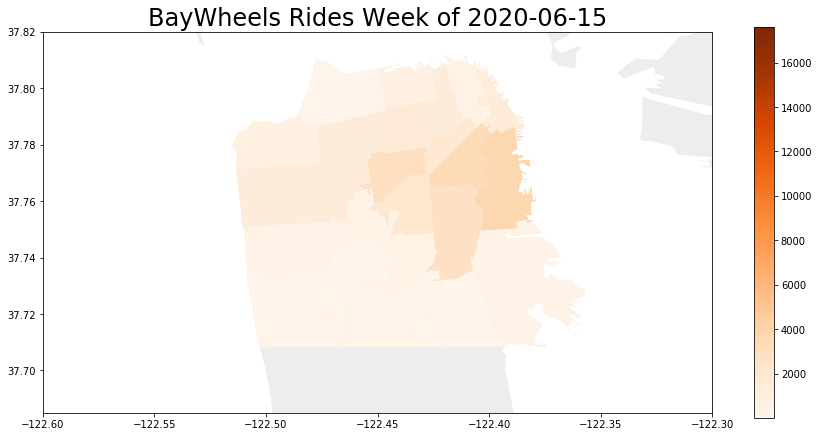

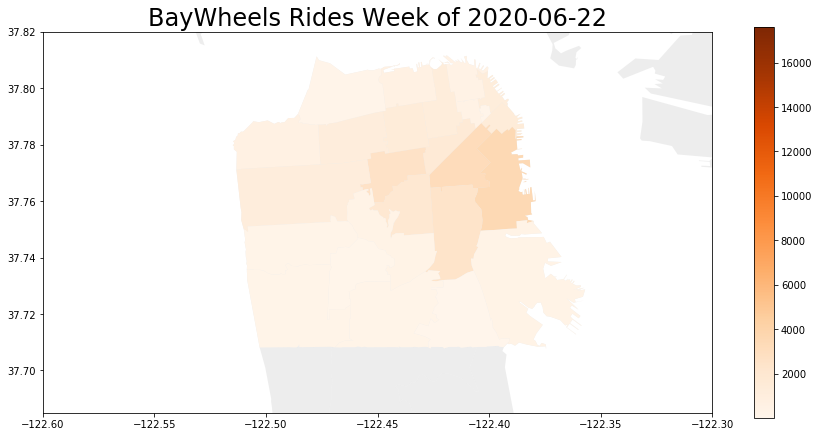

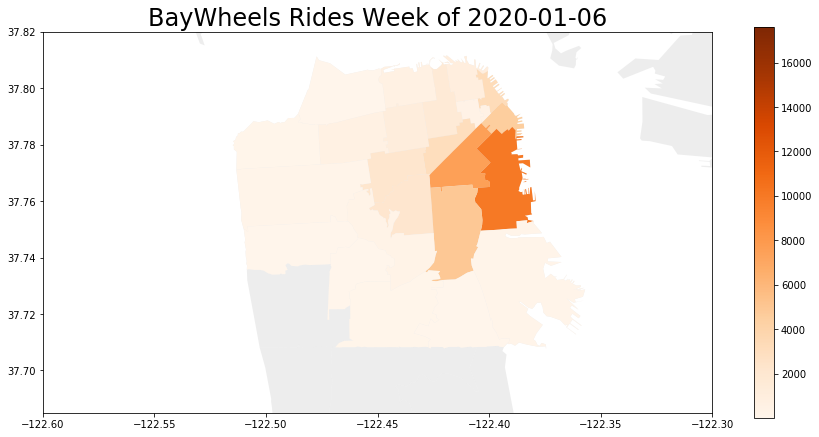

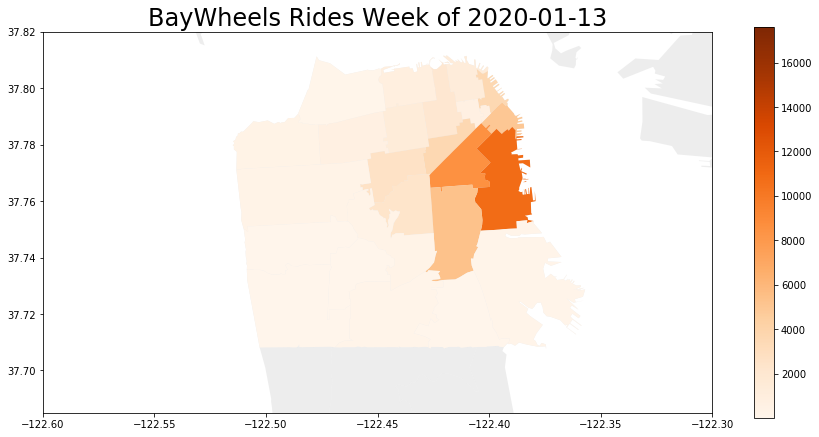

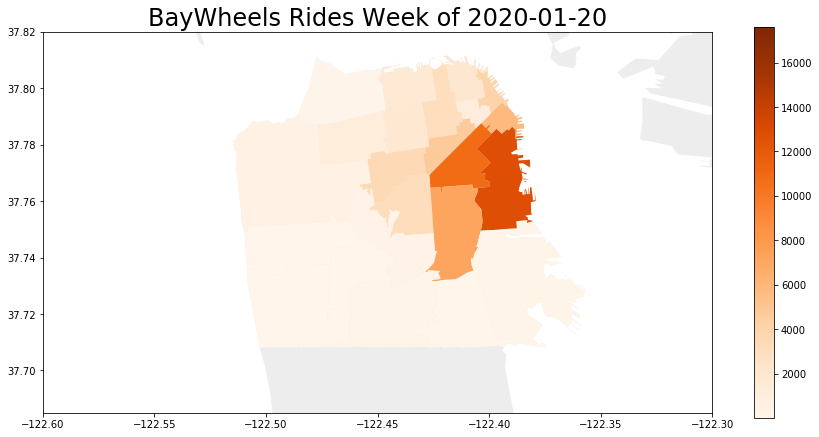

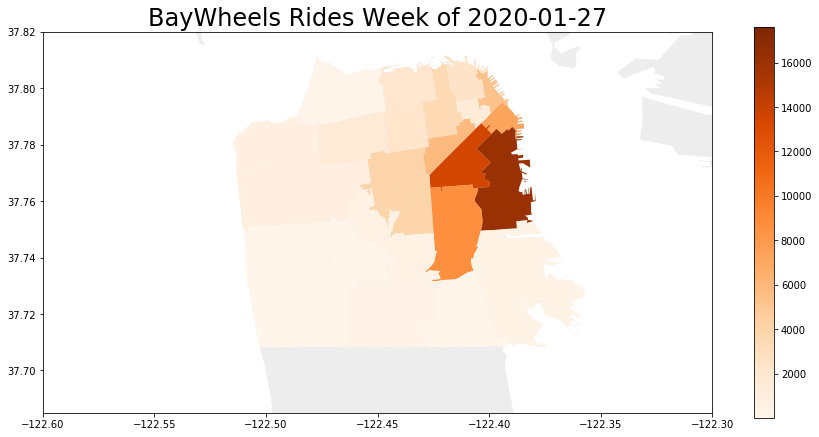

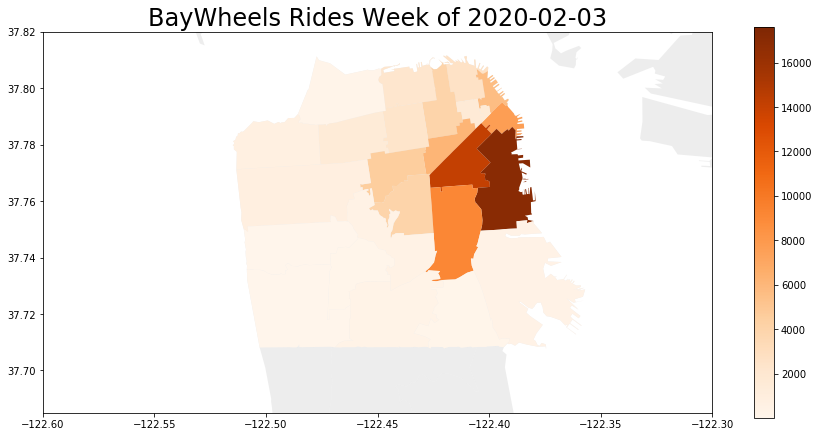

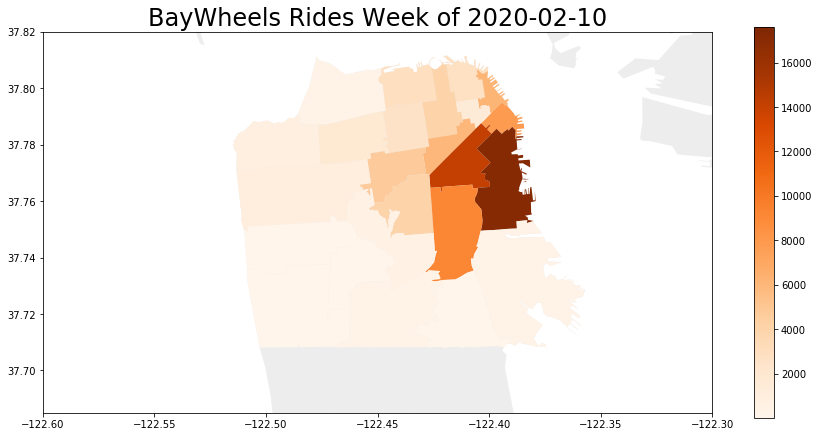

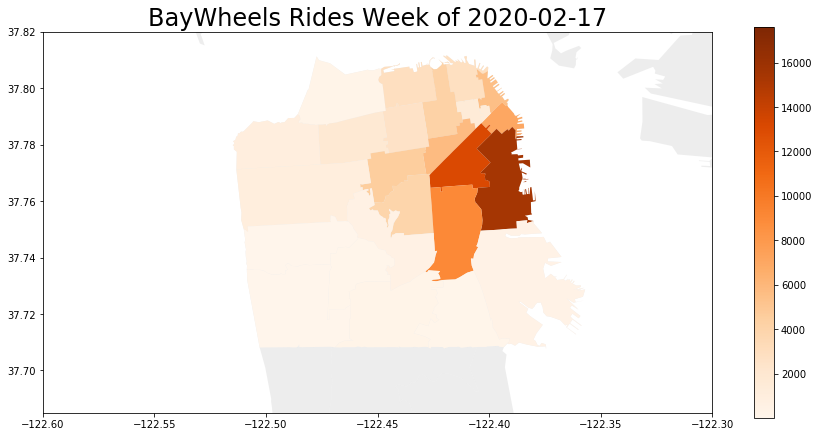

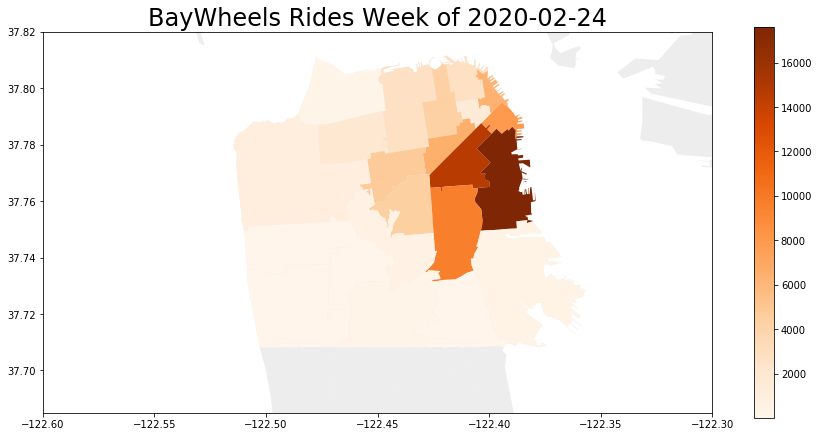

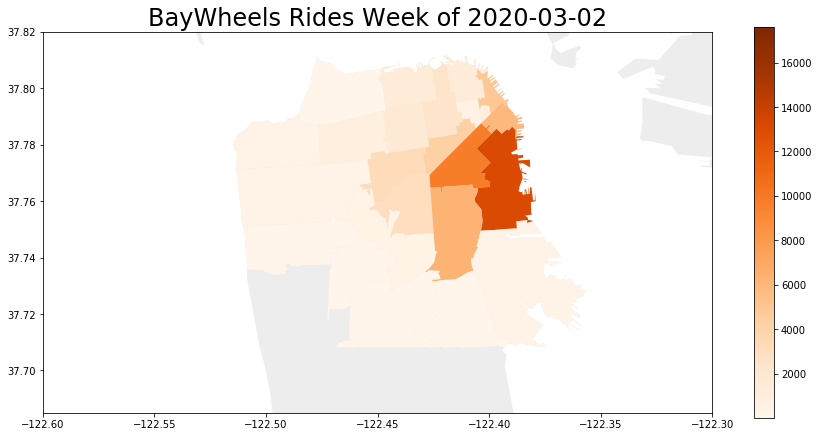

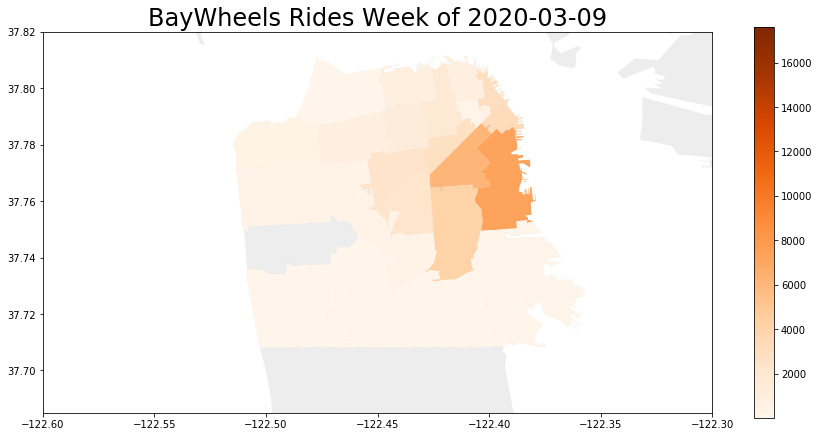

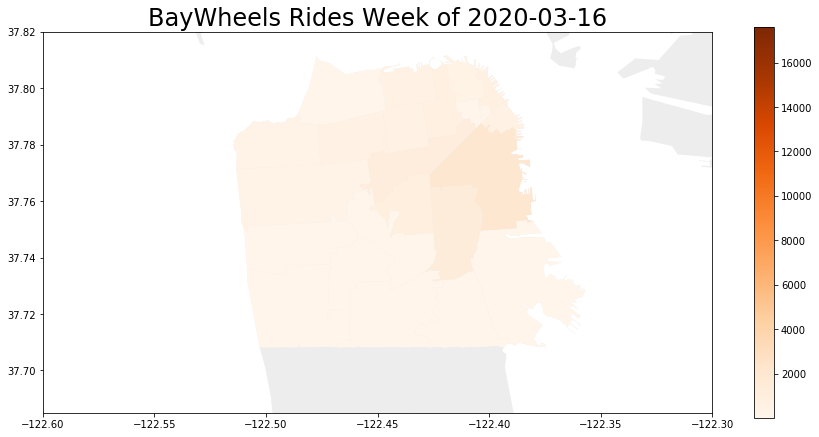

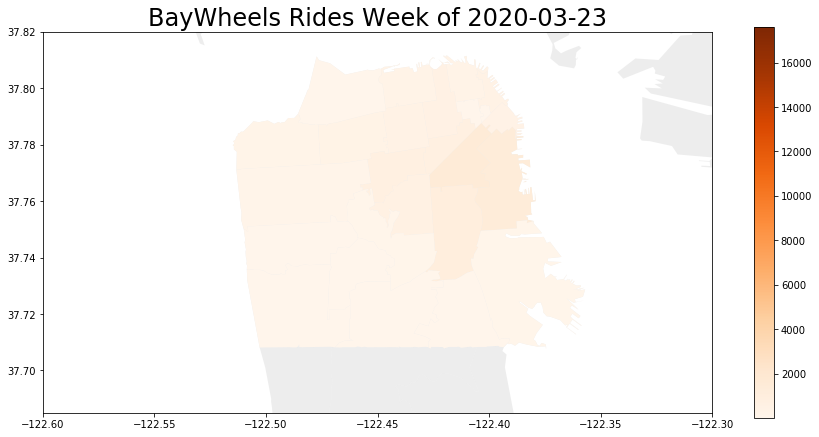

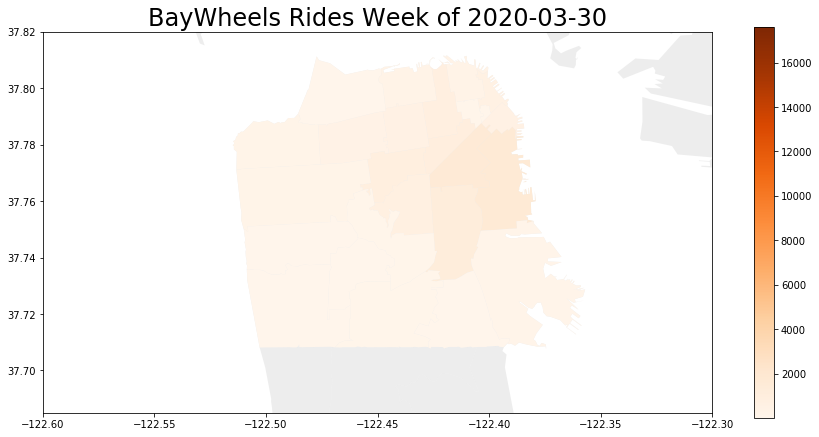

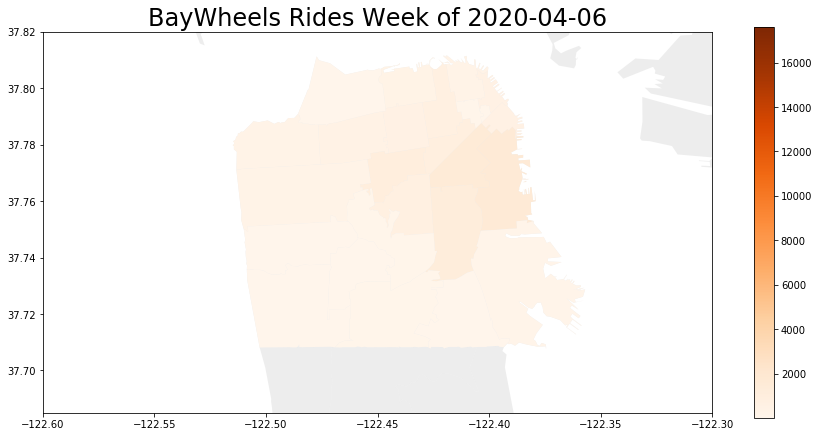

In [ ]:
## Finally calling the function. Can replace x with test data for debugging

x= geo_df_with_counts 
print_map(x)

In [ ]:
## Final GIF

convert -delay 75 *.png baywheels-project2.gif

## Sources

_This information, particularly the tutorials and guides on `Medium`, were instrumental in this project_

#### Medium Articles
1. Importing CSVs: https://medium.com/@kadek/elegantly-reading-multiple-csvs-into-pandas-e1a76843b688
2. Time lapse display: https://medium.com/@tyreus/visualizing-the-spread-of-the-2019-coronavirus-with-python-7e63230f9505
3. GeoPandas Plotting:      https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

#### Primary Sources
4. Bike Data:      https://s3.amazonaws.com/baywheels-data/index.html
5. Shape Files:    https://geodata.lib.berkeley.edu/?bbox=-127.749023+29.036961+-112.412109+45.675482&f%5Bdc_format_s%5D%5B%5D=Shapefile&f%5Bdct_spatial_sm%5D%5B%5D=San+Francisco+Bay+Area+%28Calif.%29&per_page=10

#### Formal Documentation
6. Pandas:         https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
7. GeoPanda Documentation: https://geopandas.org/reference.html
8. Matplotlib Colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html

#### Historical Context
8. Bay Wheels Feb Price Increase: https://mashable.com/article/lyft-bay-wheels-ebike-price-increase/
9. COVID Timeline in Bay Area: https://abc7news.com/timeline-of-coronavirus-us-coronvirus-bay-area-sf/6047519/